This notebook is to demonstrate the pipeline for EMG source inversion.

In [51]:
from scipy.constants import epsilon_0
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as K0, iv as I0
from scipy.linalg import solve

from EMGinv_fns import *

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay
from scipy.optimize import minimize

import pandas as pd
import scipy.io
import mat73
from pathlib import Path
import shutil
import os.path as op
import mne

# Remove magic commands if turning into a script
# %matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Load electrode positions
electrode_pos = np.load('electrode_pos.npy')

# Load source space 
xscaling, yscaling, zscaling = 1.5e-4, 1.5e-4, 0.5e-2
pos = load_src_template(filename=None, xscaling=1.5e-4, yscaling=1.5e-4, zscaling=0.5e-2)

# Load forward model
fwd = np.load('fwd_dipole.npy')
# Alternative would be to generate with
# fwd = fwd_generator(dipole_potential, pos, electrode_positions)
# And then saving with np.save('fwd_dipole.npy', fwd) - Very big file

# Load muap template waveforms 
filename = '/Users/pokhims/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/Documents/Coding/CMU_EMGSL/Data/muaps_frommatlab.mat'
muaps = scipy.io.loadmat(filename)['muaps']

# Load some data - to construct covariance matrices
MNE_raw = load_tmsitomne_combine(f_prox = 'Data/Pok_2024_08_21_A_PROX_8.poly5', f_dist='Data/Pok_2024_08_21_B_DIST_8.poly5' )

(573, 969, 26)
(1485914, 3)
[465. 466. 467. ... 471. 471. 471.]
[0. 0. 0. ... 1. 1. 1.]
Reading file  Data/Pok_2024_08_21_A_PROX_8.poly5
	 Number of samples:  892710 
	 Number of channels:  70 
	 Sample rate: 4000 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=70, n_times=892710
    Range : 0 ... 892709 =      0.000 ...   223.177 secs
Ready.
Sample rate:  4000  Hz
Channel names:  ['UNI 01', 'UNI 02', 'UNI 03', 'UNI 04', 'UNI 05', 'UNI 06', 'UNI 07', 'UNI 08', 'UNI 09', 'UNI 10', 'UNI 11', 'UNI 12', 'UNI 13', 'UNI 14', 'UNI 15', 'UNI 16', 'UNI 17', 'UNI 18', 'UNI 19', 'UNI 20', 'UNI 21', 'UNI 22', 'UNI 23', 'UNI 24', 'UNI 25', 'UNI 26', 'UNI 27', 'UNI 28', 'UNI 29', 'UNI 30', 'UNI 31', 'UNI 32', 'UNI 33', 'UNI 34', 'UNI 35', 'UNI 36', 'UNI 37', 'UNI 38', 'UNI 39', 'UNI 40', 'UNI 41', 'UNI 42', 'UNI 43', 'UNI 44', 'UNI 45', 'UNI 46', 'UNI 47', 'UNI 48', 'UNI 49', 'UNI 50', 'UNI 51', 'UNI 52', 'UNI 53', 'UNI 54', 'UNI 55', 'UNI 56', 'UNI 57', 'UNI 58', 'UNI 59', 'UN

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Filter length: 529 samples (0.132 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.8s


Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 2801 original time points ...
0 bad epochs dropped
Reducing data rank from 128 -> 128
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 16820
log-likelihood on unseen data (descending order):
   empirical: -2074.175
   shrunk: -2074.404
   diagonal_fixed: -2081.348
selecting best estimator: empirical
[done]
Reducing data rank from 128 -> 128
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG 

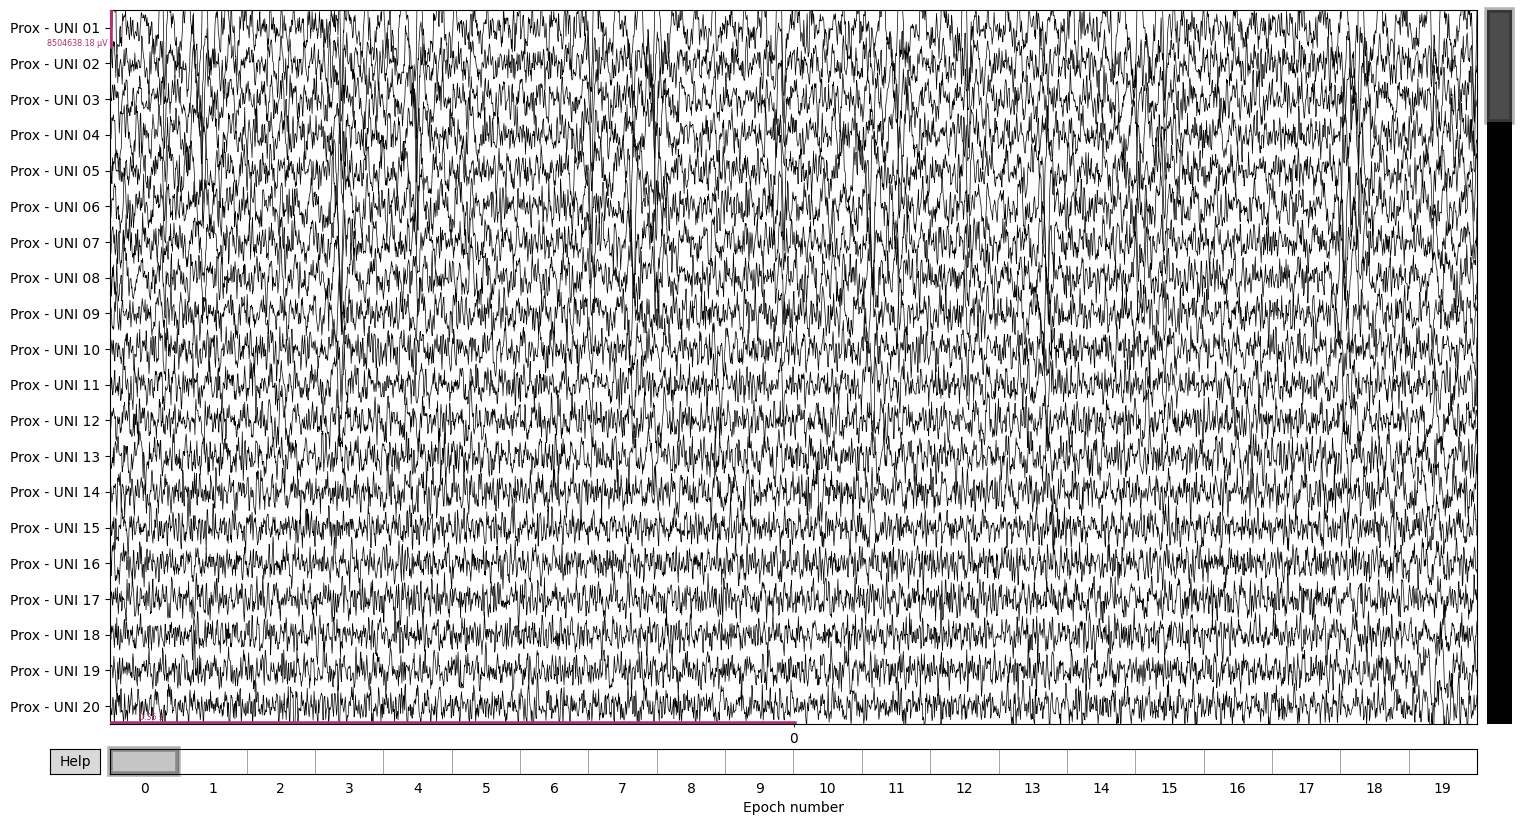

In [25]:
# Important to filter the data (highpass filter)
MNE_raw = MNE_raw.filter(l_freq=100, h_freq=None, )
# Estimate the noise covariance matrix on Epoched data.  This means that the noise covariance will be estimated on pre-stimulus periods
channel_data = MNE_raw['Prox - TRIGGERS'][0][0]-252
events = tmsi_eventextractor(channel_data)
event_dict = {'Ext': -2, 'Flex': -6} # Should be correct 
epochs = mne.Epochs(MNE_raw, events, event_dict, baseline=None, preload=True)
# Consider setting an average EEG reference across each panel of 32. 
# epochs.set_eeg_reference('average', projection=True)
# epochs.apply_proj()

noise_cov = mne.compute_covariance(epochs, method='auto', tmin=epochs.tmin, tmax=0.01)
data_cov = mne.compute_covariance(epochs, method='auto', tmin=0, tmax=epochs.tmax)

epochs.plot(n_epochs=1, scalings='auto', );

del MNE_raw, epochs, channel_data

In [26]:
# Beamformer - for online processing
# N if we want to reduce number of electrodes
N = 64

w_lcmv = lcmv_beamformer_constructor(fwd[:N,:], data_cov=data_cov.data[:N,:N], noise_cov=noise_cov.data[:N,:N])

In [27]:
# Apply beamformer
source_activity_time = np.dot(w_lcmv, muaps)

print(sys.getsizeof(source_activity_time)/8/1024/1024, 'MB')

174.30061149597168 MB


In [28]:
# Alternative algorithms:

# source_activity_time = minimum_norm_estimate(fwd[:N,:], muaps, noise_cov=noise_cov, reg=0.1)
# source_activity_time = sloreta(fwd[:N,:], muaps, noise_cov=noise_cov, reg=0.1)

In [52]:
# Equivalent Current Dipole (ECD) fitting - for offline processing - Is not currently working well.

# Objective function for the optimization
def objective_function(d_params, pos, fwd, data):
    """
    Objective function to minimize: the difference between measured data and the forward model prediction.

    Parameters:
    - d_params: Dipole parameters (n_dipoles*6). Each successive 6 indices contain the position (x, y, z) of the nth dipole and strength of each of the 3 dipole orientations.
    - pos: Position of all the source space voxels (n_voxels x 3).
    - fwd: Leadfield matrix for all of source space (n_sensors x n_voxels).
    - data: Recorded data (n_sensors x timepoints).

    Returns:
    - Error (L2-norm) between predicted data and observed data.
    """
    # Extract some useful variables
    n_dipoles = len(d_params) // 6
    # Reshape
    d_params = d_params.reshape((n_dipoles, 6), order='C')
    d_pos = d_params[:, :3]
    d_strength = d_params[:, 3:]
    d_strength = d_strength.flatten(order='C')

    # Extract the relevant parts of the leadfield matrix based on the estimated positions
    matching_indices = find_closest_rows(pos, d_pos)
    # Check if the number of matching indices is equal to the number of dipoles
    if len(matching_indices) != n_dipoles:
        print(matching_indices)
        print(d_params)
        raise ValueError("Number of matching indices does not match the number of dipoles.")
    
    # Repeat these indices 3 times for the 3 orientations
    matching_indices = np.repeat(matching_indices, 3)
    d_fwd = fwd[:, matching_indices]
    
    # Compute the predicted data
    predicted_data =  d_fwd @ d_strength.T
    
    # Calculate the L2 norm of the error
    error = np.linalg.norm(predicted_data - data)
    return error

# Main function to fit multiple dipoles
def ECD_fit_dipoles(data, fwd, pos, n_dipoles=1, initial_guess=None):
    """
    Fit multiple dipoles to the data using the ECD method.

    Parameters:
    - data: Recorded data (n_sensors x timepoints).
    - fwd: Leadfield matrix (n_sensors x n_voxels*3).
    - pos: Position of all the source space voxels (n_voxels x 3).
    - n_dipoles: Number of dipoles to fit.  Technically we are fitting 3*n_dipoles dipoles due to 3 orientations per position.
    - initial_guess: Initial guess for the dipole parameters (optional).
    
    Returns:
    - Optimal dipole parameters (positions, orientations, strengths).
    """
    if initial_guess is None:
        # Generate a random initial guess for the dipole parameters
        # Place in middle of source space if only 1 dipole
        if n_dipoles == 1:
            middle_pos = np.mean(pos, axis=0)
            initial_guess = np.ones(n_dipoles * 6)
            initial_guess[:3] = middle_pos
        # Otherwise, randomly place the dipoles within the source space
        else:
            initial_guess = np.random.rand(n_dipoles * 6)  # 3 for position, 3 for strength of each orientation
            # Scale the random values to the range of the source space
            index = np.arange(len(initial_guess))%6
            max_pos = pos.max(axis=0)
            initial_guess[index==0] = initial_guess[index==0] * max_pos[0]
            initial_guess[index==1] = initial_guess[index==1] * max_pos[1]
            initial_guess[index==2] = initial_guess[index==2] * max_pos[2]

    # Use an optimization routine to minimize the objective function
    result = minimize(objective_function, initial_guess, args=(pos, fwd, data), method='L-BFGS-B')
    print(result)
    # Adjust the position vector since we take the closest one
    d_x = result.x.reshape((n_dipoles, 6), order='C')
    d_pos = d_x[:, :3]
    d_pos = pos[find_closest_rows(pos, d_pos)]
    d_strength = d_x[:, 3:]
    
    # Return the optimized dipole parameters
    return d_pos, d_strength

# Fit 1 dipoles
n_dipoles = 1
data = muaps[:, 20]
optimal_dipoles = ECD_fit_dipoles(data, fwd[:N,:], pos, n_dipoles)

print("Optimal dipole parameters (position, strengths [x ,y ,z ] ):", optimal_dipoles)

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 530852539.35366416
        x: [ 4.296e-02  7.378e-02  5.364e-02  6.710e-06  6.710e-06
             6.710e-06]
      nit: 2
      jac: [ 0.000e+00  0.000e+00  0.000e+00  1.252e+12  1.252e+12
             1.252e+12]
     nfev: 455
     njev: 65
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
Optimal dipole parameters (position, strengths [x ,y ,z ] ): (array([[0.0429, 0.0738, 0.055 ]]), array([[6.71019537e-06, 6.71019537e-06, 6.71019537e-06]]))


# Visualisations

In [48]:
# Look at specific timepoint in the source activity
source_activity = source_activity_time[:, 20]

# Faster to reconfigure the scatter points to be in a grid, and then use imshow to plot the activity.
grid = pos_to_3Dgrid_converter(pos, source_activity, (xscaling, yscaling, zscaling))

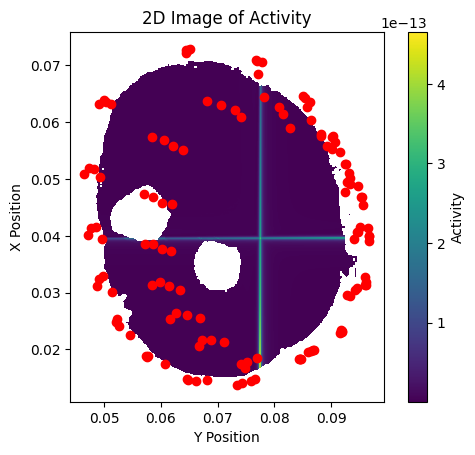

In [49]:
z = 0

# Plot the 2D image
plt.imshow(grid[:,:,z], extent=[y_min, y_max, x_min, x_max], origin='lower', cmap='viridis')
plt.colorbar(label='Activity')

plt.scatter(electrode_pos[:, 1], electrode_pos[:, 0], c='r', marker='o')
plt.xlabel('Y Position')
plt.ylabel('X Position')
plt.title('2D Image of Activity')
plt.show()

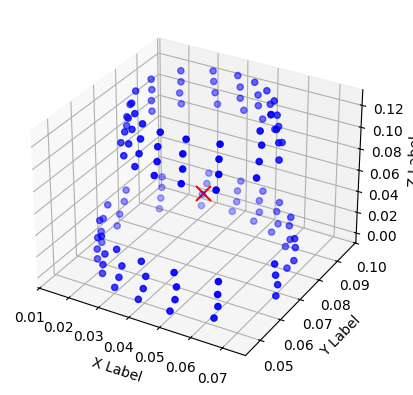

In [62]:
# Plot 3D image of electrode positions and select dipole positions

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the electrode positions
ax.scatter(electrode_pos[:, 0], electrode_pos[:, 1], electrode_pos[:, 2], c='b', marker='o')

# Centroid
# ax.scatter(weighted_centroid[0], weighted_centroid[1], weighted_centroid[2], c='r', marker='x')
# Optimal Dipoles
ax.scatter(optimal_dipoles[0][:,0], optimal_dipoles[0][:,1], optimal_dipoles[0][:,2],  c='r', marker='x', s=np.linalg.norm(optimal_dipoles[1])*1e7)
# Set labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()